In [1]:
using ReactiveMP, Rocket, GraphPPL
using Random, Distributions, LinearAlgebra, Revise
using Plots

## Solve GP regression by SDE 
In this notebook, we solve a GP regression problem by using "Stochastic Differential Equation" (SDE). This method is well described in the dissertation "Stochastic differential equation methods for spatio-temporal Gaussian process regression." by Arno Solin and "Sequential Inference for Latent Temporal Gaussian Process Models" by Jouni Hartikainen. The idea of the method is as follows.

Suppose a function $f(x)$ follows a zero-mean Gaussian Process
$$
f(x) \sim \mathcal{GP}(0, k(x,x')).
$$ 
When the dimensionality of $x$ is 1, we can consider $f(x)$ as a stochastic process over time, i.e. $f(t)$. For a certain classses of covariance functions, $f(t)$ is a solution to an $m$-th order linear stochastic differential equation (SDE)
$$
a_0 f(t) + a_1 \frac{d f(t)}{dt} + \dots + a_m \frac{d^m f(t)}{dt^m} = w(t) \quad (1)
$$ 
where $w(t)$ is a zero-mean white noise process with spectral density $Q_c$. If we define a vector-valued function $\mathbf{f}(t) = (f(t),\, d/dt f(t),\dots,\, d^{m-1}/dt^{m-1}f(t))$, then we can rewrite the above SDE under the companion form
$$
\frac{d \mathbf{f}(t)}{dt} = \mathbf{F}\, \mathbf{f}(t) + \mathbf{L} w(t) \quad (2)
$$
where $\mathbf{F}$ and $\mathbf{L}$ are defined based on the choice of covariance functions. 
From (2), we have the following state-space model:
$$
\mathbf{f}_k = \mathbf{A}_{k-1} \, \mathbf{f}_{k-1} + \mathbf{q}_{k-1}, \quad \mathbf{q}_{k-1} \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_{k-1}) \quad(3)
$$
$$
y_k = \mathbf{H} \, \mathbf{f}(t_k) + \epsilon_k , \quad \epsilon_k \sim \mathcal{N}(0, \sigma^2_{noise}) \quad(4).
$$
where $\mathbf{A}_k = \exp{(\mathbf{F}\,\Delta t_k)}$, with $\Delta t_k = t_{k+1} - t_k$, is called the discrete-time state transition matrix, and $\mathbf{Q}_k$ the process noise covariance matrix. For the computation of $\mathbf{Q}_k$, we will come back later. According to Arno Solin and Jouni Hartikainen's dissertation, the GP regression problem amounts to the inference problem of the above state-space model, and this can be solved by RTS-smoothing. The state-space model starts from  the initial state $f_0 \sim \mathcal{N}(\mathbf{0},\, \mathbf{P}_0)$. For stationary covariance function, the SDE has a stationary state $f_\infty \sim \mathcal{N}(\mathbf{0},\, \mathbf{P}_\infty)$, where $\mathbf{P}_\infty$ is the solution to
$$
\frac{d\mathbf{P}_\infty}{dt} = \mathbf{F} \mathbf{P}_\infty + \mathbf{P}_\infty \mathbf{F}^T + \mathbf{L} \mathbf{Q}_c \mathbf{L}^T = 0 \quad (\mathrm{Lyapunov \, equation}) \quad (5).
$$ 
With this stationary condition, the process noise covariance $\mathbf{Q}_k$ is computed as follows
$$
\mathbf{Q}_k = \mathbf{P}_\infty - \mathbf{A}_k \mathbf{P}_\infty \mathbf{A}_k^T \quad (6)
$$

### Covariance function: Matern-3/2
The Matern is a stationary covariance function and defined as follows
$$
k(\tau) = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left(\frac{\sqrt{2\nu}\tau}{l} \right)^\nu K_\nu\left(\frac{\sqrt{2\nu}\tau}{l} \right)
$$
where 
$$ \sigma^2: \text{the magnitude scale hyperparameter}\\
l: \text{the characteristic length-scale}\\
\nu: \text{the smoothness hyperparameter}\\
K_\nu(.): \text{the modified Bessel function of the second kind}.
$$
When we say the Matern-3/2, we mean $\nu=3/2$. For one-dimensional problem the SDE representation of the GP is defined by the matrices $\mathbf{F}, \, \mathbf{L}, \, \mathbf{Q}_c, \, \mathbf{P}_0$ and $\mathbf{H}$. For the Matern-3/2, they are computed as follows
$$
\mathbf{F} = \begin{pmatrix}
0 & 1\\
-\lambda^2 & -2\lambda
\end{pmatrix} ,\quad \quad \mathbf{L} = \begin{pmatrix}
0 \\ 1
\end{pmatrix}, \quad \quad \mathbf{P}_\infty = \begin{pmatrix}
\sigma^2 & 0 \\ 0 & \lambda^2\sigma^2
\end{pmatrix} ,\quad \quad \mathbf{H} = \begin{pmatrix}
1 & 0
\end{pmatrix}, \quad \quad Q_c = 4\lambda^3\sigma^2
$$ 
where $\lambda = \frac{\sqrt{3}}{l} $. From these matrices, we can define $\mathbf{A}_k$ and $\mathbf{Q}_k$ in the state-space model. 

## Create regression model

In [2]:
@model function gp_regression(n, P∞, A, Q, H)
    f_0 ~ MvNormalMeanCovariance([0.,0.], P∞)
    f = randomvar(n)
    y = datavar(Float64, n) where { allow_missing = true }
    
    f_prev = f_0

    for i=1:n
        f[i] ~ MvNormalMeanCovariance(A[i] * f_prev, Q[i])
        y[i] ~ NormalMeanVariance(dot(H , f[i]), 0.04)
        f_prev = f[i]
    end
    return f, y
end

In [3]:

@rule MvNormalMeanCovariance(:μ, Marginalisation) (m_out::Missing, q_Σ::PointMass, ) = missing

@rule typeof(*)(:in, Marginalisation) (m_out::Missing, m_A::PointMass, meta::TinyCorrection) = missing

@rule NormalMeanVariance(:μ, Marginalisation) (q_out::Missing, q_v::PointMass) = missing

@rule typeof(dot)(:in2, Marginalisation) (m_out::Missing, m_in1::PointMass, meta::TinyCorrection) = missing

## Generate data

In [4]:
#generate data
Random.seed!(10)
n = 100

t = collect(range(0, 5, length=n)); #timeline
f_true = 2*sin.(t) .+ cos.(2*t); # true process
f_noisy = f_true + sqrt(0.04)*randn(n); #noisy process

pos = sort(randperm(75)[1:2:75]); 
t_obser = t[pos]; # time where we observe data

y_data = Array{Union{Float64,Missing}}(missing, n)
for i in pos 
    y_data[i] = f_noisy[i]
end

θ = [1., 1.]; # store [l, σ²]
λ = sqrt(3)/θ[1];
Δt = [t[1]]; # time difference
append!(Δt, t[2:end] - t[1:end-1]);

#### compute matrices for the state-space model ######
L = [0., 1.];
H = [1., 0.];
F = [0. 1.; -λ^2 -2λ]
P∞ = [θ[2] 0.; 0. (λ^2*θ[2]) ]
A = [exp(F * i) for i in Δt]; 
Q = [P∞ - i*P∞*i' for i in A];

In [5]:
result = inference(
    model = Model(gp_regression, n, P∞, A, Q, H),
    data = (y = y_data,)
)

Inference results:
-----------------------------------------
f   = Vector{AbstractMvNormal}[[MvNormalWeightedMeanPrecision(
xi: [39.166220122121516...
f_0 = MvNormalWeightedMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNorma...


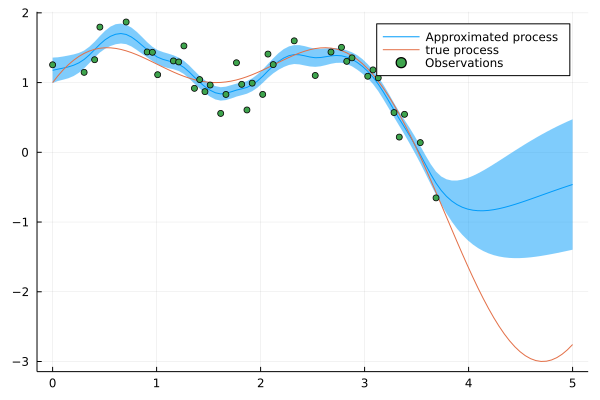

In [6]:
slicedim(dim) = (a) -> map(e -> e[dim], a)

px = plot()
px = plot!(px, t, mean.(result.posteriors[:f][]) |> slicedim(1), ribbon = var.(result.posteriors[:f][]) |> slicedim(1) .|> sqrt, label ="Approximated process")
px = plot!(px, t, f_true,label="true process")
px = scatter!(px, t_obser, f_noisy[pos], label="Observations")